In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def load_images(folder, label, size=(64, 64)):
    data, labels = [], []
    for file in os.listdir(folder):
        if file.endswith(".jpg"):
            try:
                img = Image.open(os.path.join(folder, file)).convert("RGB")
                img = img.resize(size)
                img = np.array(img) / 255.0  # normalize
                data.append(img.flatten())  # flatten to 1D
                labels.append(label)
            except:
                continue
    return data, labels

In [3]:
# Load both classes
metal_data, metal_labels = load_images(r"Dataset\metal", label=1)
paper_data, paper_labels = load_images(r"Dataset\paper", label=0)

# Combine
X = np.array(metal_data + paper_data)
y = np.array(metal_labels + paper_labels)

# Check shape
print(f"Dataset shape: {X.shape}")
print(f"Labels distribution: metal (1): {sum(y==1)}, paper (0): {sum(y==0)}")

Dataset shape: (1819, 12288)
Labels distribution: metal (1): 769, paper (0): 1050


In [4]:
from sklearn.model_selection import train_test_split

# Step 1: Split 80% train+cv and 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Split 60% train and 20% CV from the 80% temp set
X_train, X_cv, y_train, y_cv = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Print result sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Cross-validation set size: {X_cv.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 1091
Cross-validation set size: 364
Test set size: 364


In [9]:
# Activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, w, b):
    m = X.shape[0]
    z = np.dot(X, w) + b
    a = np.clip(sigmoid(z), 1e-8, 1 - 1e-8)

    cost = -np.mean(y * np.log(a + 1e-8) + (1 - y) * np.log(1 - a + 1e-8))
    return cost

def compute_gradients(X, y, w, b):
    m = X.shape[0]
    z = np.dot(X, w) + b
    a = sigmoid(z)
    dz = a - y
    dw = np.dot(X.T, dz) / m
    db = np.sum(dz) / m
    return dw, db

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

In [6]:

def train_logistic_regression(X, y, X_val, y_val, lr=0.01, num_iter=2000):
    n_features = X.shape[1]
    w = np.zeros(n_features)
    b = 0
    costs = []

    for i in range(1, num_iter + 1):
        dw, db = compute_gradients(X, y, w, b)
        w -= lr * dw
        b -= lr * db

        if i % 100 == 0:
            cost = compute_cost(X, y, w, b)
            costs.append(cost)
            print(f"Iteration {i}: Cost = {cost:.4f}")

    # Final training and validation accuracy
    train_preds = sigmoid(np.dot(X, w) + b) >= 0.5
    val_preds = sigmoid(np.dot(X_val, w) + b) >= 0.5
    
    train_acc = np.mean(train_preds == y)
    val_acc = np.mean(val_preds == y_val)
    print(f"\nTraining Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Plot cost
    plt.plot(range(100, num_iter + 1, 100), costs)
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.title("Cost vs. Iterations (Logistic Regression)")
    plt.grid(True)
    plt.show()

    return w, b


Iteration 100: Cost = 0.6095
Iteration 200: Cost = 0.5882
Iteration 300: Cost = 0.5758
Iteration 400: Cost = 0.5666
Iteration 500: Cost = 0.5591
Iteration 600: Cost = 0.5527
Iteration 700: Cost = 0.5471
Iteration 800: Cost = 0.5421
Iteration 900: Cost = 0.5375
Iteration 1000: Cost = 0.5333
Iteration 1100: Cost = 0.5293
Iteration 1200: Cost = 0.5256
Iteration 1300: Cost = 0.5220
Iteration 1400: Cost = 0.5186
Iteration 1500: Cost = 0.5154
Iteration 1600: Cost = 0.5122
Iteration 1700: Cost = 0.5092
Iteration 1800: Cost = 0.5063
Iteration 1900: Cost = 0.5035
Iteration 2000: Cost = 0.5008

Training Accuracy: 0.7910
Validation Accuracy: 0.7005


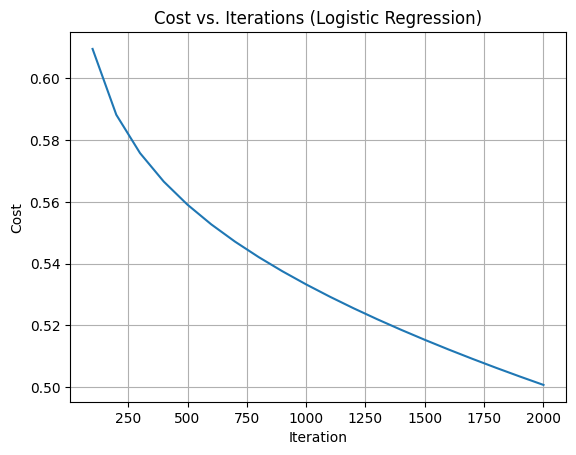

In [ ]:
w_lr, b_lr = train_logistic_regression(X_train, y_train, X_cv, y_cv, lr=0.001, num_iter=2000)

In [ ]:
# He Initialization
def initialize_parameters(n_x, n_h):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * np.sqrt(2. / n_x)
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(1, n_h) * np.sqrt(2. / n_h)
    b2 = np.zeros((1, 1))
    return W1, b1, W2, b2

# Forward propagation
def forward_prop(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X.T) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

# Cost function (no regularization)
def compute_cost(A2, Y):
    m = Y.shape[0]
    A2 = np.clip(A2.T, 1e-8, 1 - 1e-8)
    Y = Y.reshape(-1, 1)
    cost = -np.sum(Y * np.log(A2) + (1 - Y) * np.log(1 - A2)) / m
    return cost

# Backward propagation
def backward_prop(X, Y, Z1, A1, A2, W2):
    m = X.shape[0]
    Y = Y.reshape(1, -1)
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2

# Training function
def train_nn_1hidden(X, Y, X_val, Y_val, n_h=4, lr=0.001, iterations=2000):
    n_x = X.shape[1]
    W1, b1, W2, b2 = initialize_parameters(n_x, n_h)
    train_costs = []
    val_costs = []

    for i in range(1, iterations + 1):
        Z1, A1, Z2, A2 = forward_prop(X, W1, b1, W2, b2)
        _, _, _, A2_val = forward_prop(X_val, W1, b1, W2, b2)

        train_cost = compute_cost(A2, Y)
        val_cost = compute_cost(A2_val, Y_val)

        dW1, db1, dW2, db2 = backward_prop(X, Y, Z1, A1, A2, W2)

        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2

        if i % 100 == 0:
            train_costs.append(train_cost)
            val_costs.append(val_cost)
            print(f"Iteration {i}: Train Cost = {train_cost:.4f}, Val Cost = {val_cost:.4f}")

    # Final accuracy
    _, _, _, A2_train = forward_prop(X, W1, b1, W2, b2)
    _, _, _, A2_val = forward_prop(X_val, W1, b1, W2, b2)

    train_preds = A2_train.T >= 0.5
    val_preds = A2_val.T >= 0.5

    train_acc = np.mean(train_preds == Y.reshape(-1, 1))
    val_acc = np.mean(val_preds == Y_val.reshape(-1, 1))

    print(f"\nFinal Training Accuracy: {train_acc:.4f}")
    print(f"Final Validation Accuracy: {val_acc:.4f}")

    # Plot cost curves
    if train_costs:
        plt.plot(range(100, iterations + 1, 100), train_costs, label="Train Cost")
        plt.plot(range(100, iterations + 1, 100), val_costs, label="Val Cost")
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.title("Training vs Validation Cost")
        plt.legend()
        plt.grid(True)
        plt.show()

    return W1, b1, W2, b2


Iteration 100: Train Cost = 0.6150, Val Cost = 0.6374
Iteration 200: Train Cost = 0.5874, Val Cost = 0.6220
Iteration 300: Train Cost = 0.5693, Val Cost = 0.6157
Iteration 400: Train Cost = 0.5549, Val Cost = 0.6099
Iteration 500: Train Cost = 0.5416, Val Cost = 0.6033
Iteration 600: Train Cost = 0.5301, Val Cost = 0.5987
Iteration 700: Train Cost = 0.5196, Val Cost = 0.5940
Iteration 800: Train Cost = 0.5097, Val Cost = 0.5902
Iteration 900: Train Cost = 0.5009, Val Cost = 0.5869
Iteration 1000: Train Cost = 0.4933, Val Cost = 0.5842
Iteration 1100: Train Cost = 0.4864, Val Cost = 0.5817
Iteration 1200: Train Cost = 0.4796, Val Cost = 0.5793
Iteration 1300: Train Cost = 0.4730, Val Cost = 0.5771
Iteration 1400: Train Cost = 0.4669, Val Cost = 0.5752
Iteration 1500: Train Cost = 0.4609, Val Cost = 0.5734
Iteration 1600: Train Cost = 0.4553, Val Cost = 0.5719
Iteration 1700: Train Cost = 0.4498, Val Cost = 0.5704
Iteration 1800: Train Cost = 0.4447, Val Cost = 0.5689
Iteration 1900: Tra

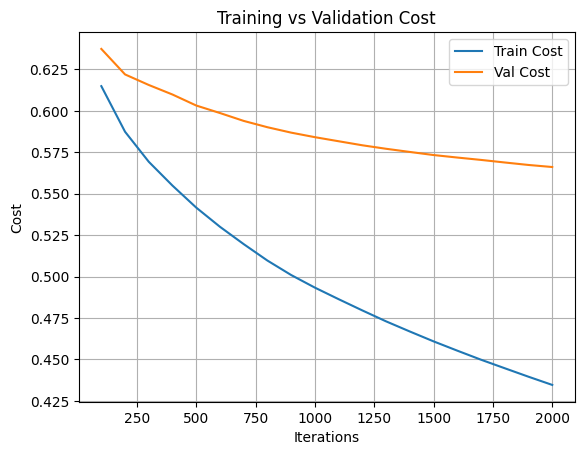

In [9]:
_ = train_nn_1hidden(X_train, y_train, X_cv, y_cv, n_h=4, lr=0.001, iterations=2000)


Iteration 100: Train Cost = 0.6914, Val Cost = 0.6919
Iteration 200: Train Cost = 0.6373, Val Cost = 0.6516
Iteration 300: Train Cost = 0.5935, Val Cost = 0.6229
Iteration 400: Train Cost = 0.5715, Val Cost = 0.6099
Iteration 500: Train Cost = 0.5558, Val Cost = 0.6011
Iteration 600: Train Cost = 0.5442, Val Cost = 0.5949
Iteration 700: Train Cost = 0.5343, Val Cost = 0.5888
Iteration 800: Train Cost = 0.5257, Val Cost = 0.5833
Iteration 900: Train Cost = 0.5176, Val Cost = 0.5777
Iteration 1000: Train Cost = 0.5096, Val Cost = 0.5727
Iteration 1100: Train Cost = 0.5007, Val Cost = 0.5674
Iteration 1200: Train Cost = 0.4949, Val Cost = 0.5628
Iteration 1300: Train Cost = 0.4955, Val Cost = 0.5660
Iteration 1400: Train Cost = 0.5115, Val Cost = 0.5814
Iteration 1500: Train Cost = 0.4470, Val Cost = 0.5336
Iteration 1600: Train Cost = 0.5033, Val Cost = 0.5963
Iteration 1700: Train Cost = 0.4630, Val Cost = 0.5519
Iteration 1800: Train Cost = 0.4204, Val Cost = 0.5279
Iteration 1900: Tra

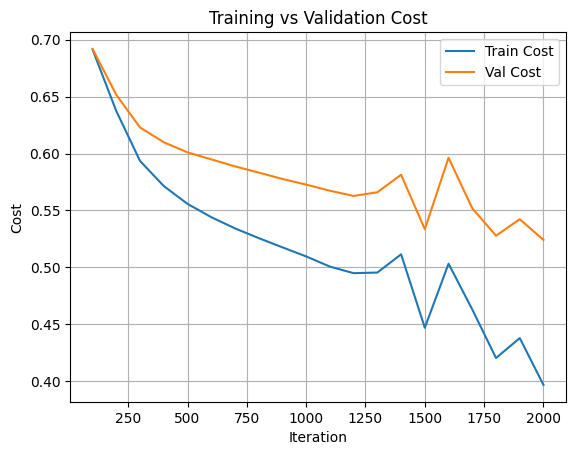

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Activation functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def sigmoid(Z):
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))

# Cost function with numerical stability
def compute_cost(A, Y):
    m = Y.shape[0]
    A = np.clip(A, 1e-8, 1 - 1e-8)
    Y = Y.reshape(1, -1)  # make sure shapes match
    return -np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / m


# He initialization
def initialize_parameters(n_x, n_h1, n_h2):
    np.random.seed(42)
    W1 = np.random.randn(n_h1, n_x) * np.sqrt(2. / n_x)
    b1 = np.zeros((n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * np.sqrt(2. / n_h1)
    b2 = np.zeros((n_h2, 1))
    W3 = np.random.randn(1, n_h2) * np.sqrt(2. / n_h2)
    b3 = np.zeros((1, 1))
    return W1, b1, W2, b2, W3, b3

# Forward pass
def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    Z1 = np.dot(W1, X.T) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# Backward pass
def backward_propagation(X, Y, Z1, A1, Z2, A2, A3, W2, W3):
    m = X.shape[0]
    dZ3 = A3 - Y.reshape(1, -1)
    dW3 = (1 / m) * np.dot(dZ3, A2.T)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

# Training function
def train_2hidden_nn(X_train, y_train, X_val, y_val, n_h1=7, n_h2=4, lr=0.0001, iterations=2000):
    y_train = y_train.flatten()
    y_val = y_val.flatten()
    n_x = X_train.shape[1]

    W1, b1, W2, b2, W3, b3 = initialize_parameters(n_x, n_h1, n_h2)
    train_costs = []
    val_costs = []

    for i in range(1, iterations + 1):
        Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X_train, W1, b1, W2, b2, W3, b3)
        _, _, _, _, _, A3_val = forward_propagation(X_val, W1, b1, W2, b2, W3, b3)

        train_cost = compute_cost(A3, y_train)
        val_cost = compute_cost(A3_val, y_val)

        dW1, db1, dW2, db2, dW3, db3 = backward_propagation(X_train, y_train, Z1, A1, Z2, A2, A3, W2, W3)

        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr * dW2
        b2 -= lr * db2
        W3 -= lr * dW3
        b3 -= lr * db3

        if i % 100 == 0:
            train_costs.append(train_cost)
            val_costs.append(val_cost)
            print(f"Iteration {i}: Train Cost = {train_cost:.4f}, Val Cost = {val_cost:.4f}")

    # Final predictions and accuracy
    _, _, _, _, _, A3_train = forward_propagation(X_train, W1, b1, W2, b2, W3, b3)
    _, _, _, _, _, A3_val = forward_propagation(X_val, W1, b1, W2, b2, W3, b3)

    train_preds = A3_train.T >= 0.5
    val_preds = A3_val.T >= 0.5

    train_acc = np.mean(train_preds == y_train.reshape(-1, 1))
    val_acc = np.mean(val_preds == y_val.reshape(-1, 1))

    print(f"\nFinal Training Accuracy: {train_acc:.4f}")
    print(f"Final Validation Accuracy: {val_acc:.4f}")

    # Plot costs
    if train_costs:
        plt.plot(range(100, iterations + 1, 100), train_costs, label="Train Cost")
        plt.plot(range(100, iterations + 1, 100), val_costs, label="Val Cost")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.title("Training vs Validation Cost")
        plt.legend()
        plt.grid(True)
        plt.show()

    return W1, b1, W2, b2, W3, b3
W1, b1, W2, b2, W3, b3 = train_2hidden_nn(X_train, y_train, X_cv, y_cv, n_h1=49, n_h2=4, lr=0.001, iterations=2000)